# Explorative study on attenuation densities in the lungs

In [4]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import *

In [5]:
%%capture
# Import from different folder
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_preprocess_dir = os.path.join(parent_dir, "DataPreprocess")

sys.path.append(data_preprocess_dir)
from main_preprocess import load_nifti_convert_to_numpy
from preprocess_tools import get_segmentations

In [ ]:
# Define parents directory
data_path = '/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data'

In [16]:
vessel_seg_output_path = data_path + '/vessel_seg/test'
get_segmentations(input_file_path=cropped_lung_ct_path_file_paths[0], output_path=vessel_seg_output_path, task="lung_vessels", fast=True)

KeyboardInterrupt: 

In [ ]:
# # Segment vessels
# vessel_seg_output_path = data_path + '/vessel_seg'

# for ct_path in cropped_lung_ct_path_file_paths:
#     get_segmentations(input_file_path=ct_path, output_path=vessel_seg_output_path, task="lung_vessels", fast=True)

In [ ]:
# Define paths
cropped_lung_ct_path = data_path + '/cropped_lungs_ct/*.nii.gz'
vessel_seg_path = data_path + '/vessel_seg/*.nii.gz'

cropped_lung_ct_path_file_paths = sorted(glob.glob(cropped_lung_ct_path))
vessel_seg_file_paths = sorted(glob.glob(vessel_seg_path))

### Load data of attenuation arrays with vessels

In [ ]:
def get_attenuation_rows(ct_paths, vessel_paths):    
# List the files in the attenuation directory
    rows = []
    for ct_path, vessel_path in zip(ct_paths, vessel_paths):
        # Load lung attenuations into numpy array and remove backgroun (-10000)
        lung_att = load_nifti_convert_to_numpy(input_path=ct_path).flatten()
        lung_att[lung_att < -4000] = 0
        
        # Load vessel segmentations and get two segmentations: one for ONLY vessels, and one WITHOUT vessels
        vessel_seg = load_nifti_convert_to_numpy(input_path=vessel_path).flatten()

        seg_only_vessels = [1 if vox == 1 else 0 for vox in vessel_seg] # set all vessels to 1, and everything else to 0
        seg_wo_vessels = [0 if vox == 1 else 1 for vox in vessel_seg] # set all vessels to 0, and everything else to 1

        # Get attenuation for ONLY vessels, and lungs WITHOUT vessels
        vessel_att = lung_att * seg_only_vessels
        lung_att_wo_vessels = lung_att * seg_wo_vessels

        patient_id = os.path.basename(ct_path)[7:10]
        new_row = {
            'lung_att': lung_att,
            'lung_att_wo_vessels': lung_att_wo_vessels,
            'vessel_att': vessel_att,
            'patient': patient_id,
            'label': 'sick' if int(patient_id) < 14 else 'healthy',
            'average_lung_att': np.mean(lung_att),
            'average_lung_att_wo_vessels': np.mean(lung_att_wo_vessels),
            'average_vessel_att': np.mean(vessel_att),
            'hpdr': get_hpdr(lung_att),
            'hpdr_we_vessels': get_hpdr(lung_att_wo_vessels),
        }
        rows.append(new_row)
    
    df = pd.DataFrame(rows).sort_values('patient').reset_index(drop=True)

    return df

In [ ]:
df = get_attenuation_rows(cropped_lung_ct_path_file_paths)

# Investigating attenuation densities with vessels

In [ ]:
# Calculate the number of plots required (5 columns per row)
total_patients = len(df)
cols = 5
rows = (total_patients + cols - 1) // cols  # Round up to nearest whole row

# Create a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()
bins = np.linspace(-1000, 200, 250)
subplot_idx = 0

# Plot each patient's attenuation data
for _, row in df.iterrows():
    attenuation_data = row['lung_att']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'limegreen' if label == 'healthy' else 'red'
    
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({label.capitalize()})")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, -200)
    HPDR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    #ax.legend([f'Mean: {mean_value:.2f}', f"HPDR: {hpdr_percent * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

# Turn off unused axes
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('attenuation Densities of 25 Patients from Pilot 1 Dataset Healthy vs Sick Patients WITH vessels', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

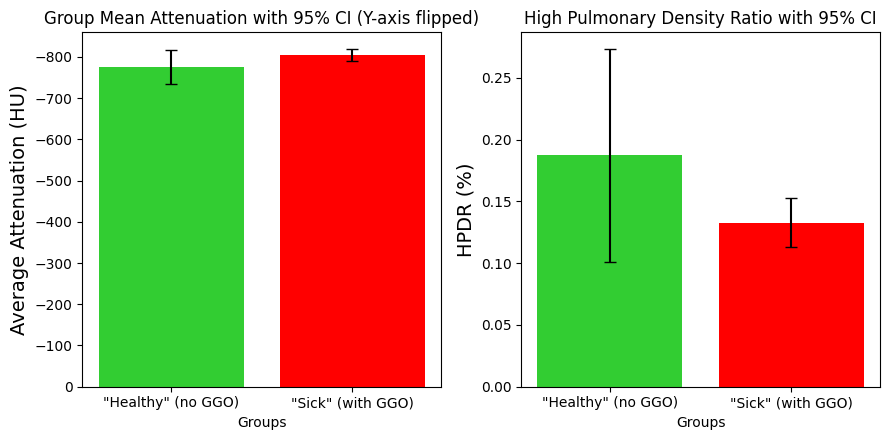

In [ ]:

# Calculate mean and standard error for attenuation
group_mean_attenuation = df.groupby('label')['average_lung_att'].mean()
group_sem_attenuation = df.groupby('label')['average_lung_att'].sem()

# Calculate 95% confidence interval range for attenuation
ci_attenuation = 1.96 * group_sem_attenuation

# Calculate mean and standard error for HPDR
group_mean_hpdr = df.groupby('label')['hpdr'].mean()
group_sem_hpdr = df.groupby('label')['hpdr'].sem()

# Calculate 95% confidence interval range for HPDR
ci_hpdr = 1.96 * group_sem_hpdr

# Define colors for each group (same for both plots)
colors = ['limegreen' if label == 'healthy' else 'red' for label in group_mean_attenuation.index]

# Define custom x-axis labels
custom_labels = ['"Healthy" (no GGO)', '"Sick" (with GGO)']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

# Plot 1: attenuation with flipped y-axis
ax1.bar(x=group_mean_attenuation.index, height=group_mean_attenuation, yerr=ci_attenuation, capsize=4, color=colors)
ax1.set_xlabel('Groups')
ax1.set_ylabel('Average attenuation (HU)', fontsize=14)
ax1.set_title('Group Mean attenuation with 95% CI (Y-axis flipped)')
ax1.invert_yaxis()  # Flip the y-axis

# Set x-ticks and labels for the first plot
ax1.set_xticks(np.arange(len(group_mean_attenuation)))  # Set the x-ticks based on the number of groups
ax1.set_xticklabels(custom_labels) 

# Plot 2: HPDR
ax2.bar(x=group_mean_hpdr.index, height=group_mean_hpdr, yerr=ci_hpdr, capsize=4, color=colors)
ax2.set_xlabel('Groups')
ax2.set_ylabel('HPDR (%)', fontsize=14)
ax2.set_title('High Pulmonary Density Ratio with 95% CI')

# Set x-ticks and labels for the second plot
ax2.set_xticks(np.arange(len(group_mean_hpdr)))  # Set the x-ticks based on the number of groups
ax2.set_xticklabels(custom_labels) 

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()

## BOXPLOT ??

In [ ]:

# Define colors for each group
colors = ['limegreen', 'red']  # Match colors for "healthy" and "sick" groups

# Define custom x-axis labels
custom_labels = ['"Healthy" (no GGO)', '"Sick" (with GGO)']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

# Plot 1: Boxplot for attenuation
sns.boxplot(data=df, x='label', y='average_lung_att', palette=colors, ax=ax1)
ax1.set_xlabel('Groups')
ax1.set_ylabel('Average attenuation (HU)', fontsize=14)
ax1.set_title('Group-wise Average attenuation (Boxplot)')
ax1.invert_yaxis()  # Flip the y-axis
ax1.set_xticklabels(custom_labels)  # Set custom x-axis labels

# Plot 2: Boxplot for HPDR
sns.boxplot(data=df, x='label', y='hpdr', palette=colors, ax=ax2)
ax2.set_xlabel('Groups')
ax2.set_ylabel('HPDR (%)', fontsize=14)
ax2.set_title('High Pulmonary Density Ratio (Boxplot)')
ax2.set_xticklabels(custom_labels)  # Set custom x-axis labels

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()


# Investigating attenuation densities without vessels

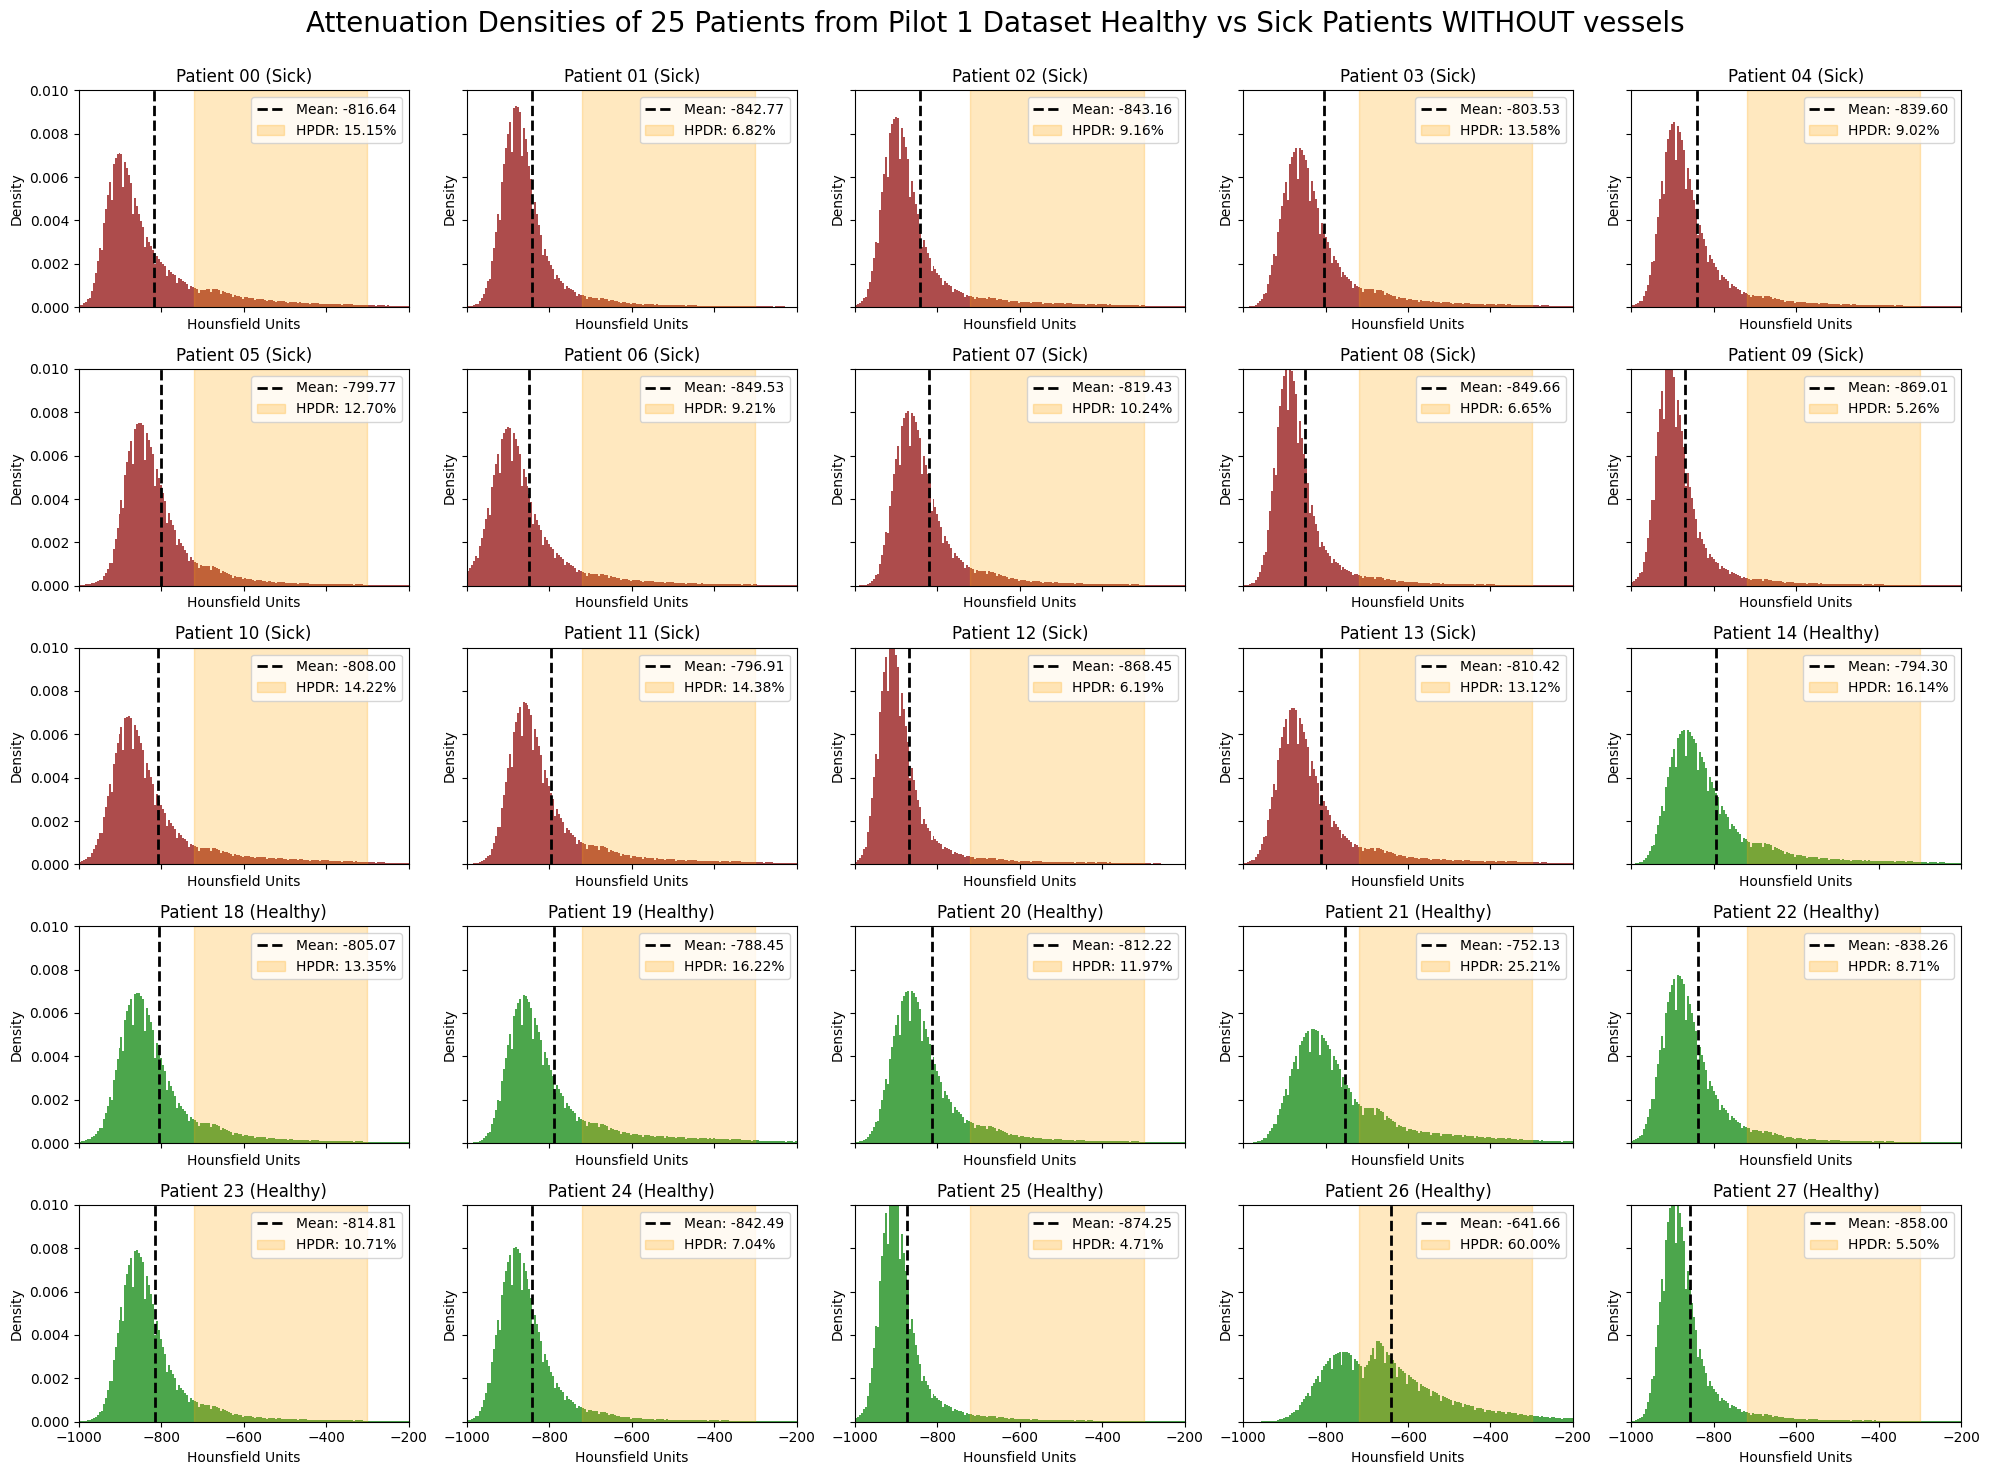

In [ ]:
# Calculate the number of plots required (5 columns per row)
total_patients = len(df)
cols = 5
rows = (total_patients + cols - 1) // cols  # Round up to nearest whole row

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 3), sharex=True, sharey=True)
axes = axes.flatten()
bins = np.linspace(-1000, 200, 250)
subplot_idx = 0

# Plot each patient's attenuation data
for _, row in df.iterrows():
    attenuation_data = row['lung_att_wo_vessels']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr_wo_vessels']
    color = 'green' if label == 'healthy' else 'darkred'
    
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({label.capitalize()})")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, -200)
    HPDR=axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

# Turn off unused axes
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('attenuation Densities of 25 Patients from Pilot 1 Dataset Healthy vs Sick Patients WITHOUT vessels', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

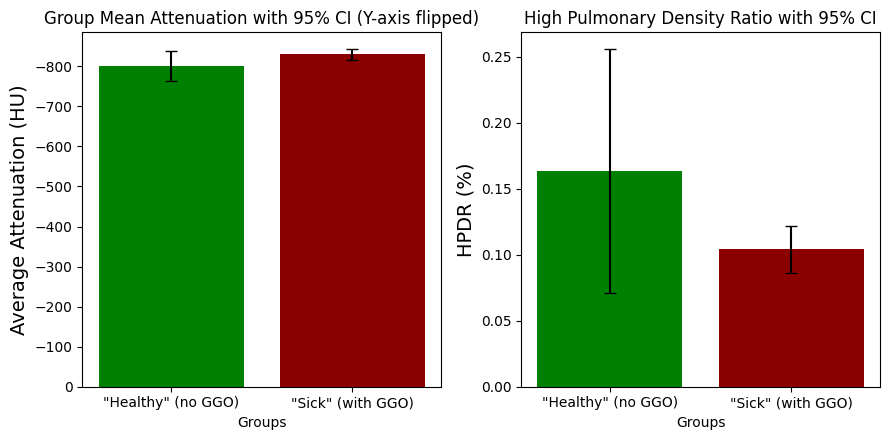

In [ ]:

# Calculate mean and standard error for attenuation
group_mean_attenuation_wo = df.groupby('label')['average_lung_att_wo_vessels'].mean()
group_sem_attenuation_wo = df.groupby('label')['average_lung_att_wo_vessels'].sem()

# Calculate 95% confidence interval range for attenuation
ci_attenuation_wo = 1.96 * group_sem_attenuation_wo

# Calculate mean and standard error for HPDR
group_mean_hpdr_wo = df.groupby('label')['hpdr_wo_vessels'].mean()
group_sem_hpdr_wo = df.groupby('label')['hpdr_wo_vessels'].sem()

# Calculate 95% confidence interval range for HPDR
ci_hpdr_wo = 1.96 * group_sem_hpdr_wo

# Define colors for each group (same for both plots)
colors = ['green' if label == 'healthy' else 'darkred' for label in group_mean_attenuation_wo.index]

# Define custom x-axis labels
custom_labels = ['"Healthy" (no GGO)', '"Sick" (with GGO)']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

# Plot 1: attenuation with flipped y-axis
ax1.bar(x=group_mean_attenuation_wo.index, height=group_mean_attenuation_wo, yerr=ci_attenuation_wo, capsize=4, color=colors)
ax1.set_xlabel('Groups')
ax1.set_ylabel('Average attenuation (HU)', fontsize=14)
ax1.set_title('Group Mean attenuation with 95% CI (Y-axis flipped)')
ax1.invert_yaxis()  # Flip the y-axis

# Set x-ticks and labels for the first plot
ax1.set_xticks(np.arange(len(group_mean_attenuation_wo)))  # Set the x-ticks based on the number of groups
ax1.set_xticklabels(custom_labels) 

# Plot 2: HPDR
ax2.bar(x=group_mean_hpdr_wo.index, height=group_mean_hpdr_wo, yerr=ci_hpdr_wo, capsize=4, color=colors)
ax2.set_xlabel('Groups')
ax2.set_ylabel('HPDR (%)', fontsize=14)
ax2.set_title('High Pulmonary Density Ratio with 95% CI')

# Set x-ticks and labels for the second plot
ax2.set_xticks(np.arange(len(group_mean_hpdr_wo)))  # Set the x-ticks based on the number of groups
ax2.set_xticklabels(custom_labels) 

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()

# Comparison of subset of the attenuation of the lungs with and without vessels  

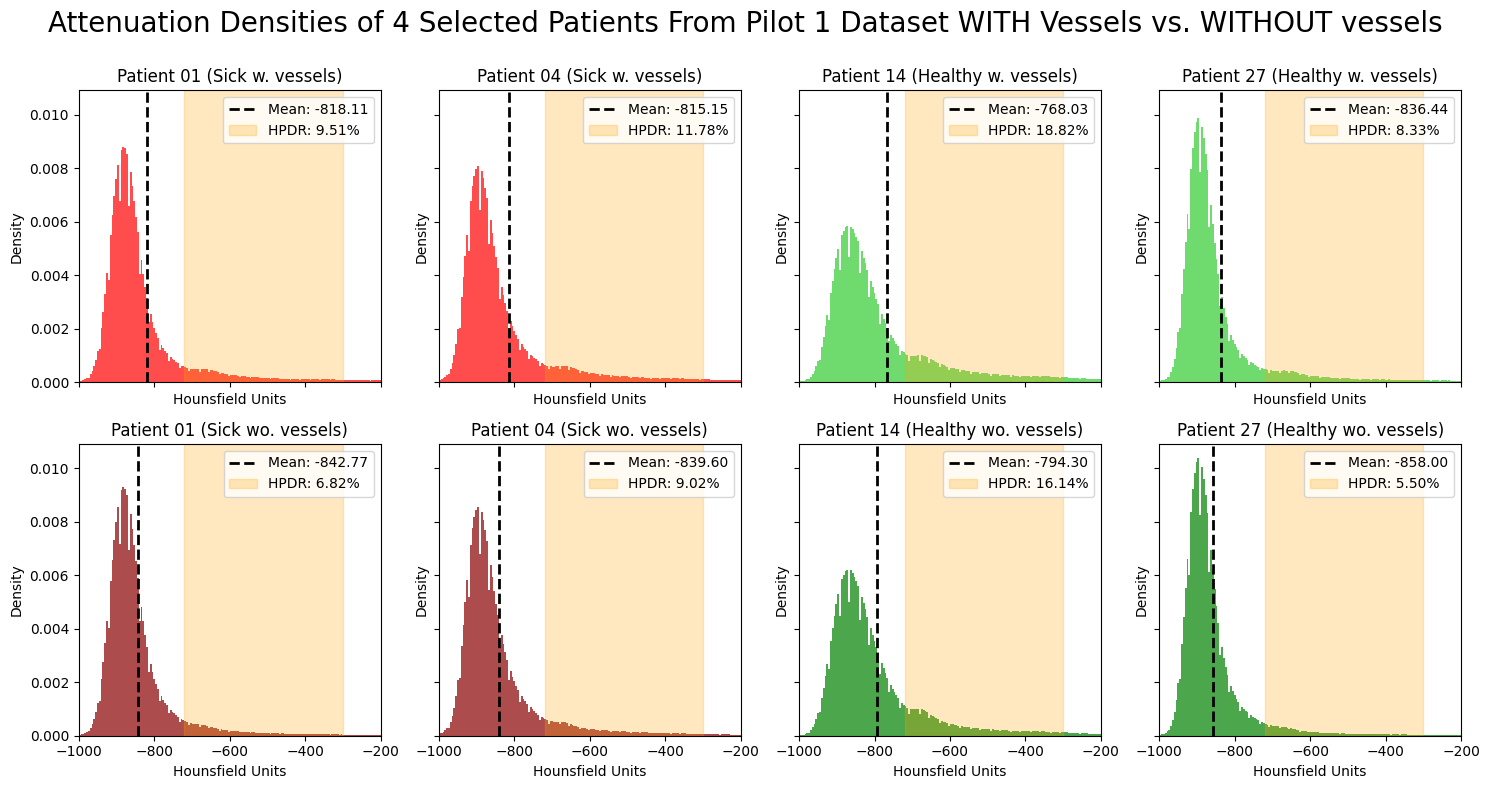

In [ ]:
#Selected patients for comparison
df_subset = df.loc[[1,4,14,24]] # Select 3 patients for comparison

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()
bins = np.linspace(-1000, 200, 250)
subplot_idx = 0


for _, row in df_subset.iterrows():
    attenuation_data = row['lung_att']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'limegreen' if label == 'healthy' else 'red'
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({label.capitalize()} w. vessels)")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    #make a horizontal line at y=100
    #axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, -200)
    HDPR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    subplot_idx += 1


for _, row in df_subset.iterrows():
    attenuation_data = row['lung_att_wo_vessels']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr_we_vessels']
    color = 'green' if label == 'healthy' else 'darkred'
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({label.capitalize()} wo. vessels)")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    #axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, -200)
    HDPR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)

    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

plt.suptitle('attenuation Densities of 4 Selected Patients From Pilot 1 Dataset WITH Vessels vs. WITHOUT vessels', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.show()

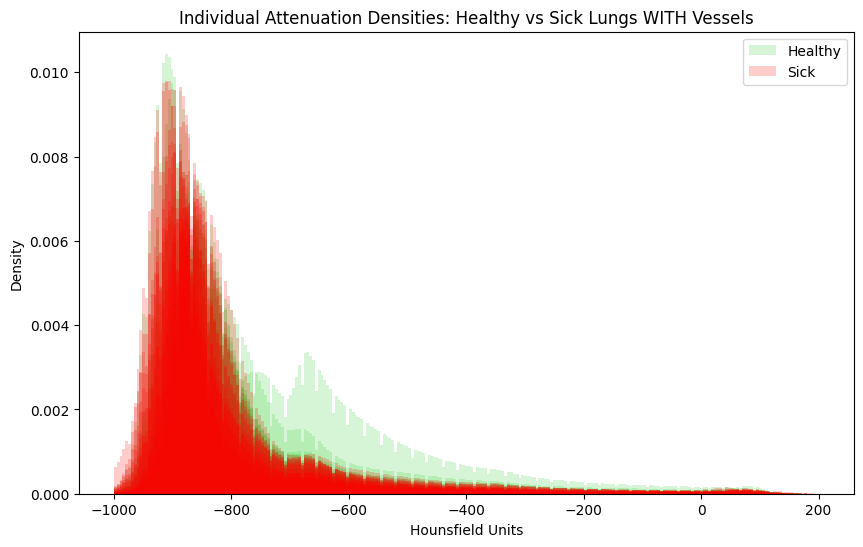

In [ ]:
plt.figure(figsize=(10, 6))
bins = np.linspace(-1000, 200, 250)

# Plot individual histograms for each healthy sample
for attenuation_data in df[df['label'] == 'healthy']['lung_att']:
    plt.hist(attenuation_data, bins=bins, alpha=0.2, density=True, color='limegreen', label="Healthy" if 'Healthy' not in plt.gca().get_legend_handles_labels()[1] else "")
# Plot individual histograms for each sick sample
for attenuation_data in df[df['label'] == 'sick']['lung_att_wo_vessels']:
    plt.hist(attenuation_data, bins=bins, alpha=0.2, density=True, color='red', label="Sick" if 'Sick' not in plt.gca().get_legend_handles_labels()[1] else "")

# Add plot details
plt.title('Individual attenuation Densities: Healthy vs Sick Lungs WITH Vessels')
plt.xlabel('Hounsfield Units')
plt.ylabel('Density')
plt.legend()
plt.show()